<a href="https://colab.research.google.com/github/oggyu/MachineLearning/blob/master/CatDogWithAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Classifying

In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


Datas gets stored in /root/.keras/datasets/cats_and_dogs_filtered as a JPG file 

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')


# python os.listdir returns list contatining the names of the entries 
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [3]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [4]:
BATCH_SIZE = 100 
IMG_SHAPE = 150 



# Data Augmentation 

Found 2000 images belonging to 2 classes.


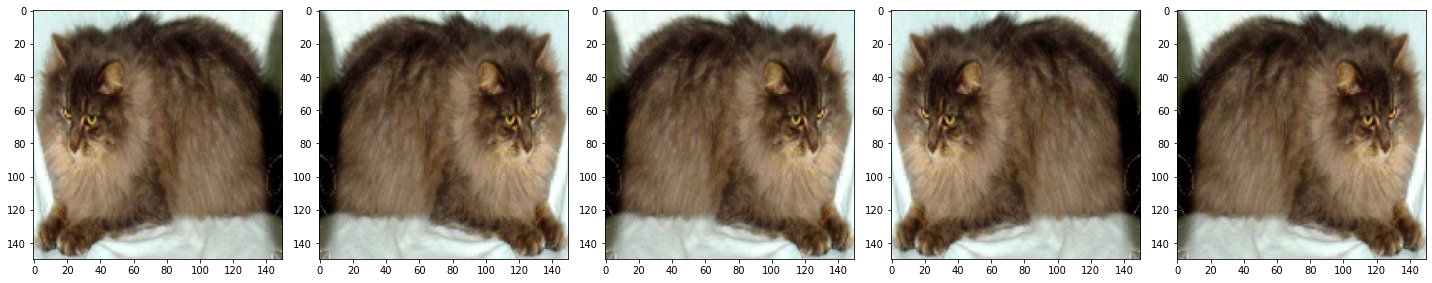

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][1] for i in range(5)]
plotImages(augmented_images)

# Data Preparing 
* read image from disk 
* decode contents and convert it to grid format RGB
* convert into floating point tensor 
* rescale tensor from 0 to 255  => 0 to 1 

All done in tf.keras.preprocessing.image.imageDataGenerator

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=40,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode='nearest')
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size =(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode = 'binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


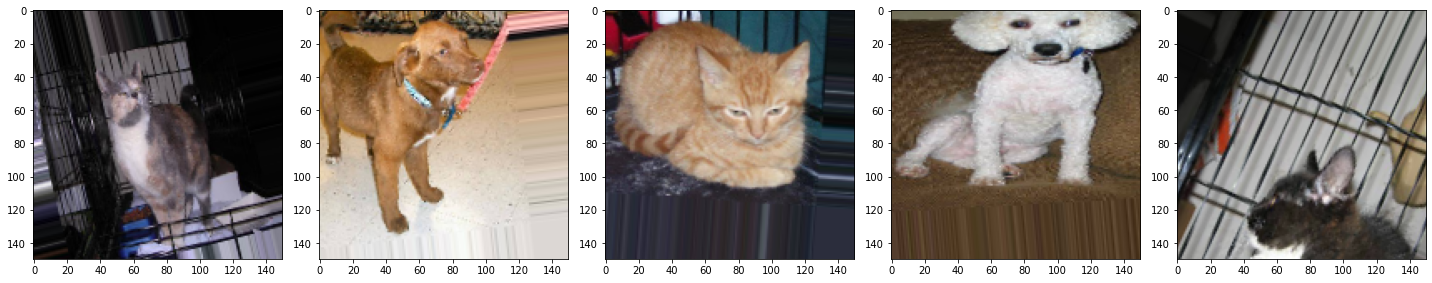

In [7]:
# augumented images and labels 
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Plot images 0-4

# 모델 만들기 Make Model
Conv32 - Pool - Conv64 - Pool - Conv128 - Pool - Conv128 - Pool - Dense512 - output2 


In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPool2D(2,2),     
  tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
  tf.keras.layers.MaxPool2D(2,2),     
  tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
  tf.keras.layers.MaxPool2D(2,2),                                
  tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
  tf.keras.layers.MaxPool2D(2,2),    
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.Dense(2)                                
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [12]:
EPOCHS = 30
history = model.fit_generator(train_data_gen,
                               steps_per_epoch = int(np.ceil(total_train/float(BATCH_SIZE))),
                               epochs = EPOCHS,
                               validation_data = val_data_gen,
                               validation_steps = int(np.ceil(total_val/float(BATCH_SIZE)))
                               )


Epoch 1/30
20/20 [==============================] - 18s 905ms/step - loss: 0.7303 - accuracy: 0.5155 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/30
20/20 [==============================] - 19s 934ms/step - loss: 0.6909 - accuracy: 0.5360 - val_loss: 0.6783 - val_accuracy: 0.6510
Epoch 3/30
20/20 [==============================] - 19s 930ms/step - loss: 0.6853 - accuracy: 0.5510 - val_loss: 0.6643 - val_accuracy: 0.6390
Epoch 4/30
20/20 [==============================] - 19s 925ms/step - loss: 0.6732 - accuracy: 0.5730 - val_loss: 0.6494 - val_accuracy: 0.6380
Epoch 5/30
20/20 [==============================] - 19s 945ms/step - loss: 0.6710 - accuracy: 0.5720 - val_loss: 0.6352 - val_accuracy: 0.6380
Epoch 6/30
20/20 [==============================] - 19s 948ms/step - loss: 0.6537 - accuracy: 0.6135 - val_loss: 0.6180 - val_accuracy: 0.6540
Epoch 7/30
20/20 [==============================] - 19s 966ms/step - loss: 0.6316 - accuracy: 0.6375 - val_loss: 0.6142 - val_accuracy: 0.6600

Overfitting 하는 것을 확인 가능

training set 을 memorizing 한다

data augmentation 과 drop out 으로 overfitting 줄였다 

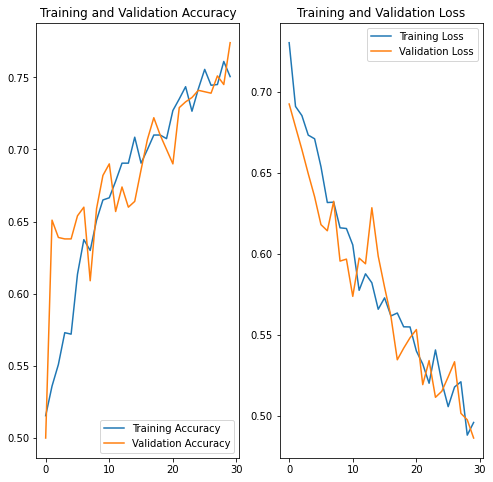

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()